In [ ]:
!pip install "deeplake<4"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.7/612.7 kB 12.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.0 MB/s eta

First Step is going to be getting all of our data imported after importing Deeplake


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import deeplake

ds = deeplake.load('hub://activeloop/plantvillage-with-augmentation')

ds.visualize()

/usr/local/lib/python3.10/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.0.3) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
-

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/plantvillage-with-augmentation



-

hub://activeloop/plantvillage-with-augmentation loaded successfully.



HINT: Please forward the port - 32995 to your local machine, if you are running on the cloud.
 * Serving Flask app 'dataset_visualizer'


 * Debug mode: off


Sweet, We have Data. Let's start preparing it for training.

In [ ]:
import deeplake
import torch
import numpy as np
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# Load the dataset
dataset = deeplake.load("hub://activeloop/plantvillage-with-augmentation")

# Create a custom PyTorch dataset
class PlantVillageDataset(torch.utils.data.Dataset):
    def __init__(self, deeplake_dataset, transform=None):
        self.dataset = deeplake_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Adjust indexing based on actual dataset structure
        image = self.dataset[idx]['images'].numpy()
        label = self.dataset[idx]['labels'].numpy()

        # Convert image to tensor and normalize
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

        # Convert label to tensor
        label_tensor = torch.tensor(label, dtype=torch.long)

        # Apply transforms if specified
        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, label_tensor

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# The Keep Indices are the indices for the peach images.
# Source: https://app.activeloop.ai/activeloop/plantvillage-with-augmentation

keep_indices = list(range(0, 1000)) + list(range(7852, 10149)) + list(range(8932,9377)) + list(range(14468,15659)) + list(range(17162,17182)) + list(range(30521, 31390)) + list(range(17183,19102)) + list(range(23163, 23792)) + list(range(52182,52802))
keep_indices.sort()
new_dataset = Subset(dataset, keep_indices)

# This will split the Dataset into only our peaches!
full_dataset = PlantVillageDataset(dataset, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=32)

print(len(train_loader),len(val_loader),len(train_dataset),len(val_dataset))
print(len(dataset['labels'].info["class_names"]))

/usr/local/lib/python3.10/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.0.3) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
-

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/plantvillage-with-augmentation



|

hub://activeloop/plantvillage-with-augmentation loaded successfully.

1470 368 47020 11755
39


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary

class PlantDiseaseClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseClassifier, self).__init__()
        self.base_model = models.resnet18(pretrained=True)

        for param in self.base_model.parameters():
            param.requires_grad = False
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        return self.base_model(x)

def inspect_data(train_loader):
    images, labels = next(iter(train_loader))
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Sample label:", labels[0])
    return images, labels

def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)



    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        count = 0
        for inputs, labels in train_loader:
            count = count + 1
            if count%10 == 0:
              print(count)
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)

            # Ensure correct shape (B, C, H, W)
            if len(inputs.shape) == 3:
                inputs = inputs.unsqueeze(0)  # Add batch dimension
            elif len(inputs.shape) == 4 and inputs.shape[1] != 3:
                inputs = inputs.permute(0, 3, 1, 2)  # Adjust channel dimension

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        model.train_losses.append(running_loss/len(train_loader))

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.float().to(device)
                labels = labels.long().to(device)

                # Ensure correct shape
                if len(inputs.shape) == 3:
                    inputs = inputs.unsqueeze(0)
                elif len(inputs.shape) == 4 and inputs.shape[1] != 3:
                    inputs = inputs.permute(0, 3, 1, 2)

                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels.squeeze()).sum().item()
        model.val_losses.append(val_loss/len(val_loader))

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {running_loss/len(train_loader):.4f}')
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
        print(f'Validation Accuracy: {100 * correct / total:.2f}%')

# Let's inspect the data first
try:
    images, labels = inspect_data(train_loader)
    print("\nData inspection successful!")
except Exception as e:
    print(f"Error during data inspection: {str(e)}")

# Initialize and train model
num_classes = len(dataset['labels'].info["class_names"])
model = PlantDiseaseClassifier(num_classes)


Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32, 1])
Sample label: tensor([8])

Data inspection successful!


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


Okay, we have our model based on ResNet 18 with the following layers and weights (the function I used to do this worked at home, didn't work in the collab environment for some reason)

```
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64, 56, 56]               0
           Conv2d-15           [-1, 64, 56, 56]          36,864
      BatchNorm2d-16           [-1, 64, 56, 56]             128
             ReLU-17           [-1, 64, 56, 56]               0
       BasicBlock-18           [-1, 64, 56, 56]               0
           Conv2d-19          [-1, 128, 28, 28]          73,728
      BatchNorm2d-20          [-1, 128, 28, 28]             256
             ReLU-21          [-1, 128, 28, 28]               0
           Conv2d-22          [-1, 128, 28, 28]         147,456
      BatchNorm2d-23          [-1, 128, 28, 28]             256
           Conv2d-24          [-1, 128, 28, 28]           8,192
      BatchNorm2d-25          [-1, 128, 28, 28]             256
             ReLU-26          [-1, 128, 28, 28]               0
       BasicBlock-27          [-1, 128, 28, 28]               0
           Conv2d-28          [-1, 128, 28, 28]         147,456
      BatchNorm2d-29          [-1, 128, 28, 28]             256
             ReLU-30          [-1, 128, 28, 28]               0
           Conv2d-31          [-1, 128, 28, 28]         147,456
      BatchNorm2d-32          [-1, 128, 28, 28]             256
             ReLU-33          [-1, 128, 28, 28]               0
       BasicBlock-34          [-1, 128, 28, 28]               0
           Conv2d-35          [-1, 256, 14, 14]         294,912
      BatchNorm2d-36          [-1, 256, 14, 14]             512
             ReLU-37          [-1, 256, 14, 14]               0
           Conv2d-38          [-1, 256, 14, 14]         589,824
      BatchNorm2d-39          [-1, 256, 14, 14]             512
           Conv2d-40          [-1, 256, 14, 14]          32,768
      BatchNorm2d-41          [-1, 256, 14, 14]             512
             ReLU-42          [-1, 256, 14, 14]               0
       BasicBlock-43          [-1, 256, 14, 14]               0
           Conv2d-44          [-1, 256, 14, 14]         589,824
      BatchNorm2d-45          [-1, 256, 14, 14]             512
             ReLU-46          [-1, 256, 14, 14]               0
           Conv2d-47          [-1, 256, 14, 14]         589,824
      BatchNorm2d-48          [-1, 256, 14, 14]             512
             ReLU-49          [-1, 256, 14, 14]               0
       BasicBlock-50          [-1, 256, 14, 14]               0
           Conv2d-51            [-1, 512, 7, 7]       1,179,648
      BatchNorm2d-52            [-1, 512, 7, 7]           1,024
             ReLU-53            [-1, 512, 7, 7]               0
           Conv2d-54            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-55            [-1, 512, 7, 7]           1,024
           Conv2d-56            [-1, 512, 7, 7]         131,072
      BatchNorm2d-57            [-1, 512, 7, 7]           1,024
             ReLU-58            [-1, 512, 7, 7]               0
       BasicBlock-59            [-1, 512, 7, 7]               0
           Conv2d-60            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-61            [-1, 512, 7, 7]           1,024
             ReLU-62            [-1, 512, 7, 7]               0
           Conv2d-63            [-1, 512, 7, 7]       2,359,296
      BatchNorm2d-64            [-1, 512, 7, 7]           1,024
             ReLU-65            [-1, 512, 7, 7]               0
       BasicBlock-66            [-1, 512, 7, 7]               0
AdaptiveAvgPool2d-67            [-1, 512, 1, 1]               0
           Linear-68                  [-1, 512]         262,656
             ReLU-69                  [-1, 512]               0
          Dropout-70                  [-1, 512]               0
           Linear-71                   [-1, 39]          20,007
           ResNet-72                   [-1, 39]               0
```



In [ ]:
train_model(model, train_loader, val_loader)



10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
Epoch 1/10
Training Loss: 0.6385
Validation Loss: 0.1899
Validation Accuracy: 93.86%
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
7

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary

class PlantDiseaseClassifier2(nn.Module):
    def __init__(self, num_classes):

        super(PlantDiseaseClassifier2, self).__init__()

        # Load the pre-trained VGG16 model
        self.base_model = models.vgg16(pretrained=True)

        # Freeze the weights of the base model
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        self.base_model.classifier[-1] = nn.Linear(self.base_model.classifier[-1].in_features, num_classes)

        self.train_losses = []
        self.val_losses = []

        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        return self.base_model(x)

def inspect_data(train_loader):
    images, labels = next(iter(train_loader))
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Sample label:", labels[0])
    return images, labels

def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)



    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        count = 0
        for inputs, labels in train_loader:
            count = count + 1
            if count%10 == 0:
              print(count)
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)

            # Ensure correct shape (B, C, H, W)
            if len(inputs.shape) == 3:
                inputs = inputs.unsqueeze(0)  # Add batch dimension
            elif len(inputs.shape) == 4 and inputs.shape[1] != 3:
                inputs = inputs.permute(0, 3, 1, 2)  # Adjust channel dimension

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        model.train_losses.append(running_loss/len(train_loader))

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.float().to(device)
                labels = labels.long().to(device)

                # Ensure correct shape
                if len(inputs.shape) == 3:
                    inputs = inputs.unsqueeze(0)
                elif len(inputs.shape) == 4 and inputs.shape[1] != 3:
                    inputs = inputs.permute(0, 3, 1, 2)

                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels.squeeze()).sum().item()
        model.val_losses.append(val_loss/len(val_loader))

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {running_loss/len(train_loader):.4f}')
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
        print(f'Validation Accuracy: {100 * correct / total:.2f}%')

# Let's inspect the data first
try:
    images, labels = inspect_data(train_loader)
    print("\nData inspection successful!")
except Exception as e:
    print(f"Error during data inspection: {str(e)}")

# Initialize and train model
num_classes = len(dataset['labels'].info["class_names"])
new_model = PlantDiseaseClassifier2(num_classes)

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32, 1])
Sample label: tensor([35])

Data inspection successful!


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 200MB/s]


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
Epoch 1/10
Training Loss: 0.6485
Validation Loss: 0.3457
Validation Accuracy: 88.96%
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
7

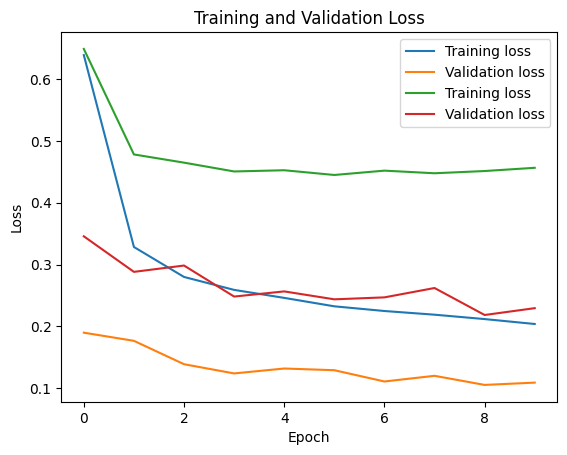

In [ ]:
train_model(new_model, train_loader, val_loader)

plt.plot(model.train_losses, label='Training loss')
plt.plot(model.val_losses, label='Validation loss')
plt.plot(new_model.train_losses, label='Training loss')
plt.plot(new_model.val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

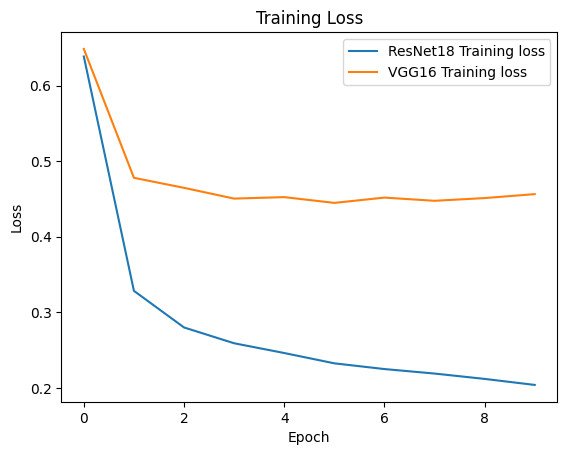

In [ ]:
plt.plot(model.train_losses, label='ResNet18 Training loss')
plt.plot(new_model.train_losses, label='VGG16 Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

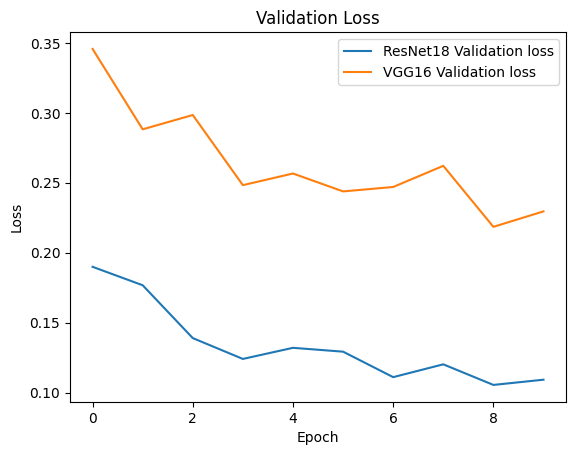

In [ ]:
plt.plot(model.val_losses, label='ResNet18 Validation loss')
plt.plot(new_model.val_losses, label='VGG16 Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss')
plt.show()

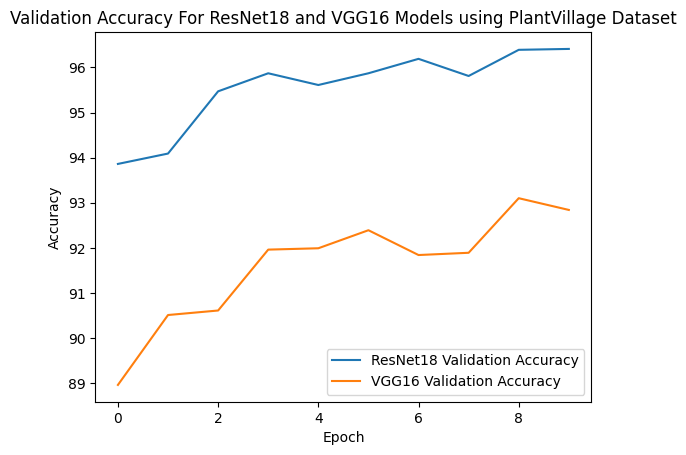

In [ ]:
resnet_accuracies = [93.86,94.09,95.47,95.87,95.61,95.87,96.19,95.81,96.39,96.41]
VGG16_accuracies = [88.96,90.51, 90.61,91.96,91.99,92.39,91.84,91.89,93.10,92.84]

plt.plot(resnet_accuracies, label='ResNet18 Validation Accuracy')
plt.plot(VGG16_accuracies, label='VGG16 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy For ResNet18 and VGG16 Models using PlantVillage Dataset')
plt.show()




Final Accuracy after 10 Epochs with Full Data:

ResNet 18 Model: 96.41%

VGG16 Model: 92.84%



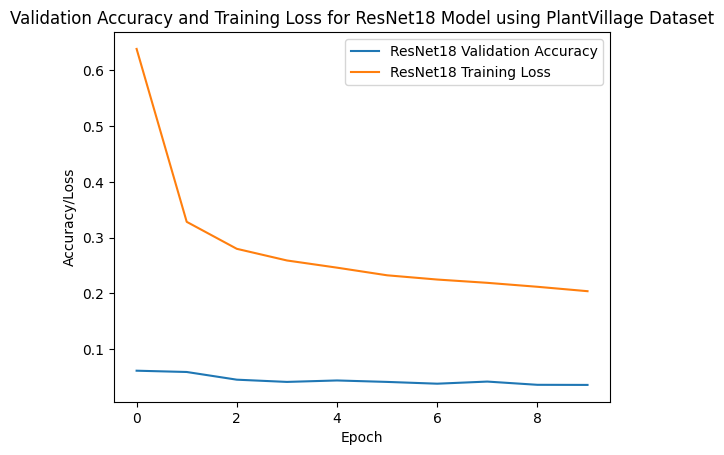

In [ ]:
resnet_accuracies = [1-.9386,1-.9409,1-.9547,1-.9587,1-.9561,1-.9587,1-.9619,1-.9581,1-.9639,1-.9641]
resnet_training_loss = [.6385,.3284,.2800,.2591,.2462,.2325,.2249,.2190,.2119,.2040]

plt.plot(resnet_accuracies, label='ResNet18 Validation Accuracy')
plt.plot(resnet_training_loss, label='ResNet18 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.title('Validation Accuracy and Training Loss for ResNet18 Model using PlantVillage Dataset')
plt.show()

In [ ]:
print(model.eval)

print(new_model.eval)

<bound method Module.eval of PlantDiseaseClassifier(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, 